# Stiff Van der Pol

The stiff version of the Van der Pol oscillator is a common test problem for stiff differential equations.
It is low dimensional.
It is also a second-order ODE, and this notebook evaluates how much to gain by solving it as such.

In [1]:
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from diffeqzoo import backend, ivps
from jax import config

from probdiffeq import controls, ivpsolvers
from probdiffeq.doc_util import benchmark, info, notebook, workprecision
from probdiffeq.statespace import recipes
from probdiffeq.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()


ProbDiffEq version:
	0.1.5.dev90+dirty
Diffrax version:
	0.3.1
SciPy version:
	1.10.1

Most recent ProbDiffEq commit:
	b'92ee3a\n'

jax:    0.4.6
jaxlib: 0.4.4
numpy:  1.24.2
python: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


In [3]:
stiffness_constant = 1e5
f_2nd, u0_2nd, (t0, t1), f_args = ivps.van_der_pol(
    stiffness_constant=stiffness_constant
)
u0_2nd = (jnp.atleast_1d(u0_2nd[0]), jnp.atleast_1d(u0_2nd[1]))


@jax.jit
def vf_2nd(x, dx, *, t, p):
    return f_2nd(x, dx, *f_args)


problem_2nd = benchmark.SecondOrderIVP(
    vector_field=vf_2nd, initial_values=u0_2nd, t0=t0, t1=t1
)

In [4]:
f, u0, (t0, t1), f_args = ivps.van_der_pol_first_order(
    stiffness_constant=stiffness_constant
)


@jax.jit
def vf(x, *, t, p):
    return f(x, *f_args)


problem = benchmark.FirstOrderIVP(vector_field=vf, initial_values=(u0,), t0=t0, t1=t1)

problem_scipy = problem.to_scipy(t_eval=[t0, t1])
problem_diffrax = problem.to_diffrax()
problems = {
    "probdiffeq-second": problem_2nd,
    "probdiffeq-first": problem,
    "diffrax": problem_diffrax,
    "scipy": problem_scipy,
}

In [5]:
# Compute a reference solution
scipy_solution = scipy.integrate.solve_ivp(
    *problem_scipy.args,
    atol=1e-13,
    rtol=1e-13,
    method="LSODA",
)

# Select all remaining problem parameters
rtols = 0.1 ** jnp.arange(1.0, 9.0, step=1.0)
atols = 1e-2 * rtols
num_repeats = 3
error_fn = benchmark.relative_rmse(solution=scipy_solution.y.T[-1, 0])

solve_fn_2nd = benchmark.probdiffeq_terminal_values(select_fn=lambda x: x[0])
solve_fn = benchmark.probdiffeq_terminal_values(select_fn=lambda x: x[0])
solve_fn_diffrax = benchmark.diffrax_terminal_values(select_fn=lambda x: x[0])
solve_fn_scipy = benchmark.scipy_terminal_values(select_fn=lambda x: x[0])
solve_fns = {
    "probdiffeq-second": solve_fn_2nd,
    "probdiffeq-first": solve_fn,
    "diffrax": solve_fn_diffrax,
    "scipy": solve_fn_scipy,
}

# Bundle the problem setup
problem_config = workprecision.ProblemConfig(
    label=f"Van der Pol (const={stiffness_constant}; terminal-value simulation)",
    problems=problems,
    error_fn=error_fn,
    solve_fns=solve_fns,
    atols=atols,
    rtols=rtols,
    repeat=num_repeats,
    error_unit="RMSE, relative",
)

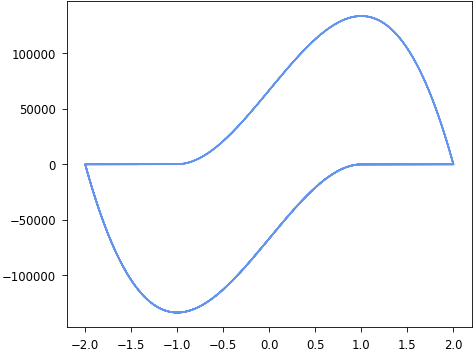

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
colors = ["C" + str(i) for i in range(7)]
y = scipy_solution.y.T
plt.plot(y[:, 0], y[:, 1], marker="None")
plt.show()

In [7]:
# Some helper functions


def impl_to_method_config(impl, *, key, label):
    return strategy_to_method_config(filters.filter(*impl), key=key, label=label)


def strategy_to_method_config(strategy, *, key, label):
    # Use a solver_dynamic because vdP has such aggressively
    # different output scales
    solver = ivpsolvers.solver_dynamic(*strategy)

    # Use a clipped control because |f(u0)|=0 which is why
    # the initial step-size suggestion becomes a little bit fragile.
    return workprecision.MethodConfig(
        method={"solver": solver, "control": controls.ProportionalIntegralClipped()},
        label="ProbDiffEq: " + label,
        key=key,
        jit=True,
        plotting_kwargs={"color": "C0"},
    )


def diffrax_method_config(solver, label):
    return workprecision.MethodConfig(
        method={"solver": solver, "max_steps": 10_000},
        label="Diffrax: " + label,
        jit=True,
        key="diffrax",
        plotting_kwargs={"color": "C3"},
    )


def scipy_method_config(method):
    return workprecision.MethodConfig(
        method={"method": method},
        label="SciPy: " + method,
        jit=False,
        key="scipy",
        plotting_kwargs={"color": "C2"},
    )

In [8]:
# The second order solvers receive one additional derivative
# to match the "highest derivative" in the state-space model
# to those that transform the IVP into first-order form
num_derivatives_low = 2
num_derivatives = 4

ts1 = recipes.ts1_dense(ode_shape=u0.shape, num_derivatives=num_derivatives)
ts1_2nd = recipes.ts1_dense(
    ode_shape=u0_2nd[0].shape, ode_order=2, num_derivatives=num_derivatives + 1
)
ts1_2nd_low_order = recipes.ts1_dense(
    ode_shape=u0_2nd[0].shape, ode_order=2, num_derivatives=num_derivatives_low + 1
)

# Methods
methods = [
    diffrax_method_config(solver=diffrax.Kvaerno5(), label="Kvaerno5()"),
    scipy_method_config(method="LSODA"),
    scipy_method_config(method="Radau"),
    impl_to_method_config(
        ts1_2nd_low_order,
        key="probdiffeq-second",
        label=f"DenseTS1({num_derivatives_low+1}, 2nd)",
    ),
    impl_to_method_config(
        ts1_2nd,
        key="probdiffeq-second",
        label=f"DenseTS1({num_derivatives+1}, 2nd)",
    ),
    impl_to_method_config(
        ts1, key="probdiffeq-first", label=f"DenseTS1({num_derivatives}, 1st)"
    ),
]

In [9]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

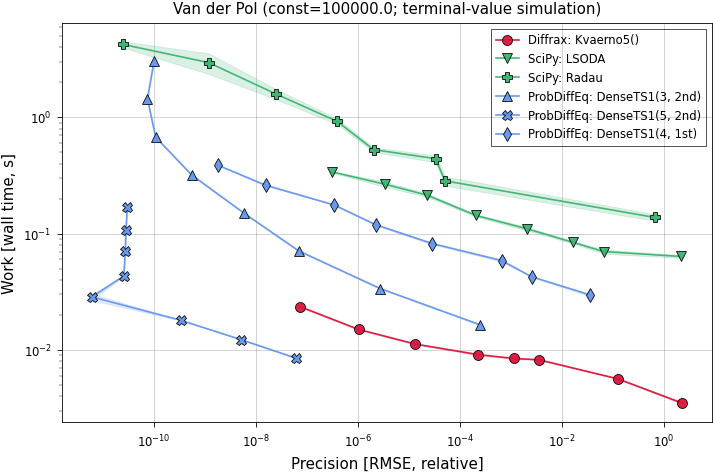

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = workprecision.plot(
    results=results,
    fig=fig,
    ax=ax,
    title=problem_config.label,
    xlabel_unit=problem_config.error_unit,
)
plt.show()